# Generación aleatoria de carteras

En este caso vamos a trabajar con aproximadamente 500 activos y vamos a contruir carteras con ellos, con el objetivo de practicar los números aleatorios.

## Descarga de los datos del S&P 500

In [51]:
import yfinance as yf

sp500 = yf.download(["SPY"], start="2018-12-31", end="2023-12-31")
sp500 = sp500.loc[:, ["Adj Close"]]
sp500.columns = ["SP500"]

[*********************100%%**********************]  1 of 1 completed


## Descarga de los datos de los componentes del S&P 500

Descarga de los componentes del S&P 500.

Refs.:
* Componentes del S&P 500: https://en.wikipedia.org/wiki/List_of_S%26P_500_companies#S&P_500_component_stocks
* Módulo Requests: https://requests.readthedocs.io/en/latest/
* Módulo BeautifulSoup: https://www.crummy.com/software/BeautifulSoup/bs4/doc/

In [7]:
# Hacemos webscrapping de la wikipedia para descargar los componentes del SP500 y guardarlos en un archivo CSV.
import pandas as pd
import requests  # Módulo para realizar peticiones HTTP
from bs4 import BeautifulSoup  # Módulo para hacer scraping

# URL de la página de la wikipedia
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'

# Realizamos la petición a la página
page = requests.get(url)

# Creamos el objeto BeautifulSoup
soup = BeautifulSoup(markup=page.content, features='html.parser')

# Buscamos la tabla que contiene los datos
table = soup.find("table", {"id": "constituents"})

# Extraemos los datos de la tabla
data = []
for row in table.find_all('tr')[1:]:
    cols = row.find_all('td')
    data.append((cols[0].text.strip(), cols[1].text.strip()))

# Creamos un DataFrame con los datos
df = pd.DataFrame(data, columns=['Symbol', 'Name'])

# Guardamos el DataFrame en un archivo csv
df.to_csv('../data/sp500.csv', index=False)

Descarga de los precios de cierre de los activos.

In [10]:
import yfinance as yf

# Obtenemos los tickers de los activos y los convertimos a una lista.
tickers = list(df.loc[:, "Symbol"])

# Descargamos los datos de precios desde Yahoo Finance.
data = yf.download(tickers, start="2018-12-31", end="2023-12-31")
data = data.loc[:, "Adj Close"]

# Guardamos el DataFrame en un archivo csv
data.to_csv('../data/sp500_adj_close.csv')

[****************      33%%                      ]  168 of 503 completed

$BF.B: possibly delisted; No price data found  (1d 2018-12-31 -> 2023-12-31)


[*********************100%%**********************]  503 of 503 completed

5 Failed downloads:
['SW', 'SOLV', 'GEV']: YFChartError("%ticker%: Data doesn't exist for startDate = 1546232400, endDate = 1703998800")
['BF.B']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2018-12-31 -> 2023-12-31)')
['BRK.B']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')


## Análisis y limpieza de los datos

In [39]:
import pandas as pd

# Cargamos los datos de los precios de cierre ajustados.
data = pd.read_csv('../data/sp500_adj_close.csv', index_col="Date", parse_dates=True)
data.shape

(1259, 503)

In [54]:
# Nos quedamos con el último año de datos.
data = data.iloc[-252:, :]
sp500 = sp500.iloc[-252:, :]

print(data.shape)
print(sp500.shape)

(252, 496)
(252, 1)


<Axes: >

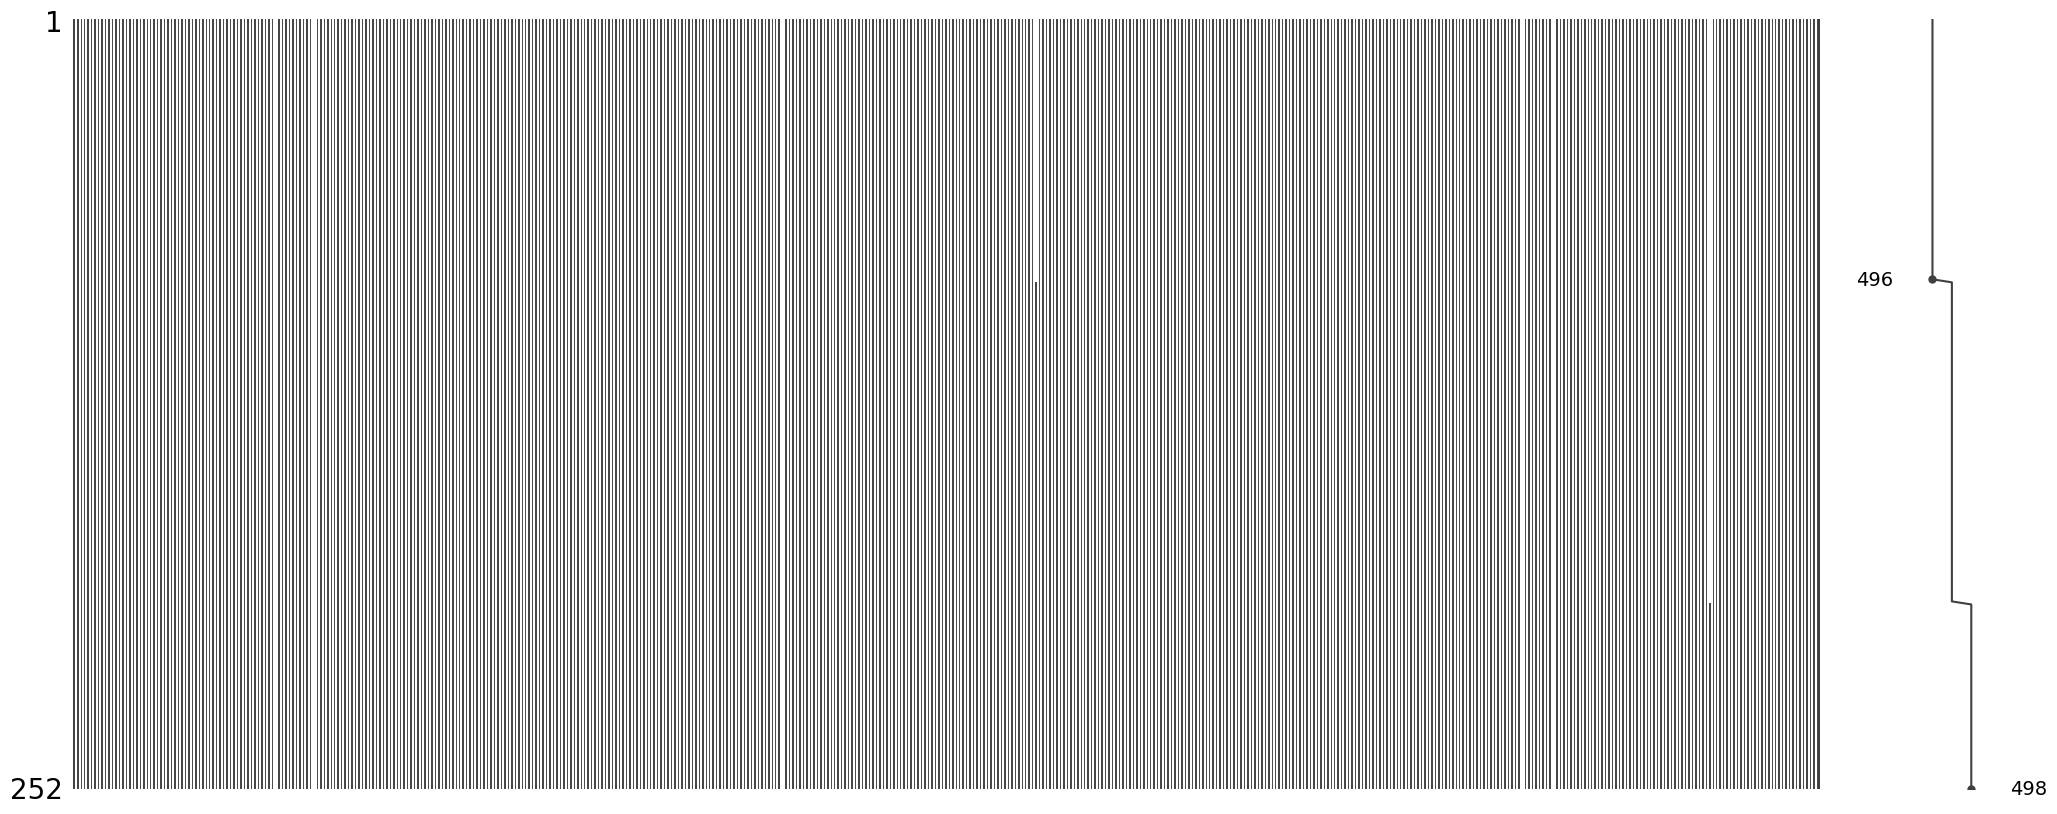

In [41]:
import missingno as mso

mso.matrix(data)

Vamos a eliminar todos los activos que tienen algún dato a NaN.

In [44]:
data = data.dropna(axis=1, how="any")
data.shape

(252, 496)

## Generación de aleatoria de una cartera

Nuestro objetivo consiste en crear 1 cartera de 5 activos seleccionados aleatoriamente a partir de los activos que nos hemos descargado y comparar su rendimiento con el S&P 500.

Para ello utilizaremos la librería ``Numpy`` y su capacidad de generación de números aleatorios.

Refs.:
* Random Generator: https://numpy.org/doc/stable/reference/random/generator.html

**NOTA**: Cuidado, la forma de generar números aleatorios en Numpy ha cambiado no hace mucho y ChatGPT tiende a generar código de la forma antigua...

In [141]:
import numpy as np


def seleccionar_activos(lista_activos: np.ndarray, num_activos: int, replace=False, random_seed:int=None) -> np.ndarray:
    """Selecciona aleatoriamente un número dado de activos de una lista de activos.

    Args:
        lista_activos (list): Lista de todos los activos.
        num_activos (int): Número de activos a seleccionar aleatoriamente.
        replace (bool): Indica si se pueden seleccionar elementos repetidos.
        random_seed (int): Semilla para el generador de números aleatorios.

    Returns:
        list: Lista de activos seleccionados
    """
    # Creamos el generador de números aleatorios.
    # Si fijamos la semilla, obtendremos siempre los mismos resultados
    rng = np.random.default_rng(seed=random_seed)

    # Seleccionamos aleatoriamente los activos siguiendo una distribución uniforme.
    # replace = True -> podemos seleccionar el mismo elemento más de una vez.
    # replace = False -> no podemos seleccionar el mismo elemento más de una vez.
    activos_seleccionados = rng.choice(lista_activos, size=num_activos, replace=replace)

    # Devolvemos la lista de activos seleccionados.
    return activos_seleccionados


activos_seleccionados = seleccionar_activos([1, 2, 3, 4, 5], 3)
activos_seleccionados

array([5, 3, 2])

Seleccionamos los activos que formarán parte de nuestra cartera.

In [93]:
num_activos = 5
activos_seleccionados = seleccionar_activos(
    lista_activos=data.columns.values,
    num_activos=num_activos,
    replace=False,
    random_seed=42
)
activos_seleccionados

array(['PRU', 'HBAN', 'MSI', 'AVB', 'GWW'], dtype=object)

Ahora necesitamos asignar el peso que tendrá cada activo en nuestra cartera, es decir, si tenemos 100 EUR ¿cuánto vamos a comprar de cada uno de los activos? Por sencillez, vamos a optar por una cartera equiponderada, que significa que todos los activos pesarán lo mismo.

In [95]:
# Calculamos el porcentaje de nuestro patrimonio que asignaremos a cada activo.
w = [1 / num_activos] * num_activos
w

[0.2, 0.2, 0.2, 0.2, 0.2]

Observad la diferencia entre esto:

```python
[1 / num_activos] * num_activos
```
y esto:

```python
np.multiply([1 / num_activos], num_activos)
```

In [96]:
[1 / num_activos] * num_activos

[0.2, 0.2, 0.2, 0.2, 0.2]

In [97]:
np.multiply([1 / num_activos], num_activos)

array([1.])

## Comparación de nuestra cartera con el S&P 500

Vale. A estas alturas tenemos:
* Precios del S&P 500.
* Precios de los componentes del S&P 500.
* Una forma de seleccionar aleatoriamente activos.
* Unos activos seleccionados para nuestra cartera.
* Unos pesos asignados a nuestros activos.

¿Qué tenemos que hacer a continuación?
1. Rentabilidades logarítmicas del S&P 500.
2. Rentabilidades logarítmicas de los componentes del S&P 500.
3. Seleccionar las rentabilidades de los activos que formarán parte de nuestra cartera.
4. Calcular la rentabilidad histórica de nuestra cartera.
5. Comparar la rentabilidad histórica de nuestra cartera con la del S&P 500.
6. Calcular la rentabilidad anualizada esperada de nuestra cartera y del S&P 500.
7. Calcular la volatilidad anualizada de nuestra cartera y del S&P 500.
8. Comparar la rentabilidad esperada y la volatilidad de nuestra cartera y la del S&P 500.

Calcular las rentabilidades logarítmicas del S&P 500.

In [98]:
# TODO: Ejercicio.

In [99]:
sp500_ret = np.log(sp500).diff().dropna()

Calcular las rentabilidades logarítmicas de los componentes del S&P 500.

In [ ]:
# TODO: Ejercicio.

In [101]:
data_ret = np.log(data).diff().dropna()

Seleccionar las rentabilidades de los activos que formarán parte de nuestra cartera.

In [ ]:
# TODO: Ejercicio.

In [110]:
activos_seleccionados_ret = data_ret.loc[:, activos_seleccionados]
print(activos_seleccionados_ret.shape)

(251, 5)


Calcular la rentabilidad de nuestra cartera.

In [ ]:
# TODO: Ejercicio.

In [115]:
# (251, 5) · (5, 1) = (251, 1)
portfolio_ret = activos_seleccionados_ret @ w
portfolio_ret

Date
2022-12-30   -0.005791
2023-01-03   -0.000340
2023-01-04    0.010302
2023-01-05   -0.021044
2023-01-06    0.027172
                ...   
2023-12-22    0.002072
2023-12-26    0.004273
2023-12-27    0.002002
2023-12-28    0.002215
2023-12-29   -0.003258
Length: 251, dtype: float64

Comparar la rentabilidad histórica de nuestra cartera con la del S&P 500.

In [ ]:
# TODO: Ejercicio.

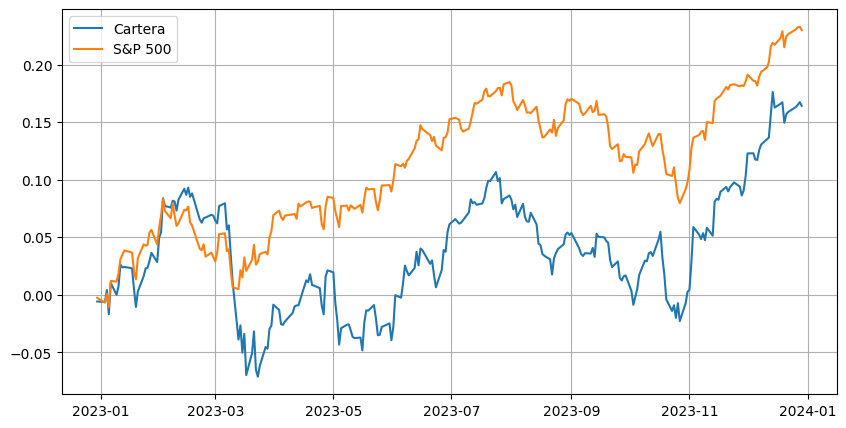

In [120]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(portfolio_ret.cumsum(), label="Cartera")
plt.plot(sp500_ret.cumsum(), label="S&P 500")
plt.grid(True)
plt.legend()
plt.show()

Calcular la rentabilidad anualizada esperada de nuestra cartera y del S&P 500.

In [ ]:
# TODO: Ejercicio.

In [121]:
portfolio_ret_annualized = portfolio_ret.mean() * 252
sp500_ret_annualized = sp500_ret.mean() * 252

Calcular la volatilidad anualizada de nuestra cartera y del S&P 500.

In [ ]:
# TODO: Ejercicio.

In [122]:
portfolio_std_annualized = portfolio_ret.std() * np.sqrt(252)
sp500_std_annualized = sp500_ret.std() * np.sqrt(252)

Crear un gráfico que compare la rentabilidad esperada (eje Y) y la volatilidad (eje X) de nuestra cartera y la del S&P 500.

In [ ]:
# TODO: Ejercicio.

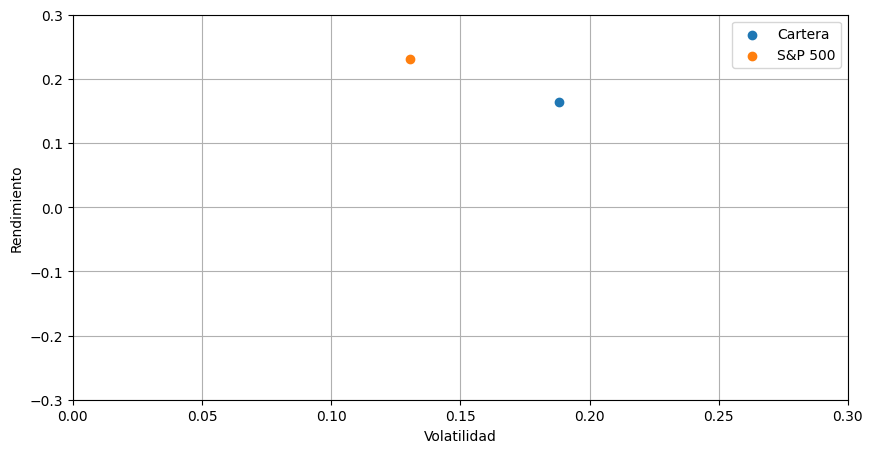

In [126]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.scatter(portfolio_std_annualized, portfolio_ret_annualized, label="Cartera")
plt.scatter(sp500_std_annualized, sp500_ret_annualized, label="S&P 500")
plt.xlabel("Volatilidad")
plt.ylabel("Rendimiento")
plt.xlim(0, 0.3)
plt.ylim(-0.3, 0.3)
plt.grid(True)
plt.legend()
plt.show()

## Generación aleatoria de 1000 carteras

Nuestro objetivo consiste en crear 10000 carteras de 30 activos seleccionados aleatoriamente a partir de los activos que nos hemos descargado y comparar su rendimiento esperado y su volatilidad con las del S&P 500.

Anteriormente seleccionamos aleatoriamente 5 activos de todos los disponibles.

In [149]:
num_activos = 5
activos_seleccionados = seleccionar_activos(
    lista_activos=data.columns.values,
    num_activos=num_activos,
    replace=True,
    random_seed=42,
)
print(activos_seleccionados.shape)
print(activos_seleccionados)

(5,)
['AVGO' 'PSX' 'MTB' 'HBAN' 'GWW']


Ahora le pedimos que nos genere 10000 combinaciones de 30 elementos, es decir 10000 carteras de 30 activos seleccionados aleatoriamente con reemplazo.

In [175]:
num_activos = (10000, 30)  # 10000 carteras, 30 activos por cartera
activos_seleccionados = seleccionar_activos(
    lista_activos=data.columns.values,
    num_activos=num_activos,
    replace=True,
    random_seed=42
)
activos_seleccionados.shape

(10000, 30)

Calculamos las rentabilidades esperadas anualizadas y las volatilidades anualizadas de cada cartera generada.

In [180]:
# Número de activos por cartera.
n = activos_seleccionados.shape[1]

# Lista que guardará los retornos esperados anualizados.
retornos_p = []
# Lista que guardará las volatilidades anualizadas.
volatilidades_p = []

# "activos_seleccionados" tiene la forma (10000, 30)
# len(activos_seleccionados) = activos_seleccionados.shape[0] = 10000
# range(len(activos_seleccionados)) va de 0 a 9999
# Luego "idx" va tomando los valores 0, 1, 2, ..., 9998, 9999
for idx in range(len(activos_seleccionados)):
    # Obtenemos los rendimientos de los activos seleccionados.
    activos_ret = data_ret.loc[:, activos_seleccionados[idx]]  # (251, 30)

    # Calculamos los pesos de los activos en la cartera.
    w = [1 / n] * n  # (30, )

    # Calculamos la rentabilidad de nuestra cartera.
    portfolio_ret = activos_ret @ w  # (251, 30) · (30, ) = (251, )

    # Calculamos rendimiento esperado anualizado.
    portfolio_ret_annualized = portfolio_ret.mean() * 252
    retornos_p.append(portfolio_ret_annualized)

    # Calculamos la volatilidad anualizada.
    portfolio_std_annualized = portfolio_ret.std() * np.sqrt(252)
    volatilidades_p.append(portfolio_std_annualized)

In [181]:
print(f"Número de retornos = {len(retornos_p)}")
print(f"Número de volatilidades = {len(volatilidades_p)}")

Número de retornos = 10000
Número de volatilidades = 10000


Calculamos las rentabilidades esperadas anualizadas y volatilidades anualizadas de cada activo por separado.

In [188]:
retornos_a = data_ret.mean() * 252
volatilidades_a = data_ret.std() * np.sqrt(252)

Y por último graficamos todos puntos en los ejes rentabilidad/riesgo.

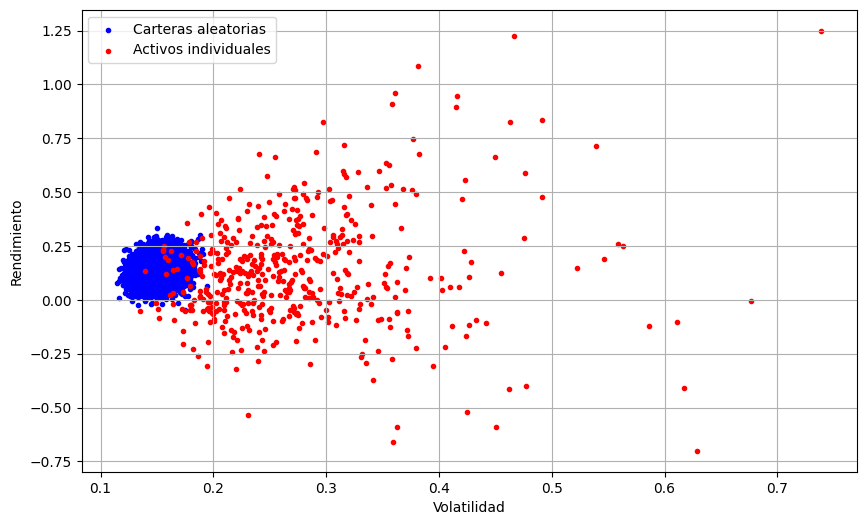

In [193]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(volatilidades_p, retornos_p, color="blue", marker=".",label="Carteras aleatorias")
plt.scatter(volatilidades_a, retornos_a, color="red", marker=".", label="Activos individuales")
plt.xlabel("Volatilidad")
plt.ylabel("Rendimiento")
plt.legend()
plt.grid(True)
plt.show()

## Simulación de Montecarlo

Hasta ahora lo que hemos hecho es:
1. A partir de un conjunto de activos, construir carteras de forma aletatoria y analizar sus retornos y volatilidades.
2. Comparar el retorno y volatilidad de una cartera aleatoria con su índice de referencia.
3. Comparar carteras aleatorias con los propios activos de los que están compuestas.

En resumen, hemos estudiado el pasado y hemos comparado con otros activos. Ahora vamos a estudiar probables futuros y compararnos con nosotros mismos.

El método de Montecarlo se basa en la generación de un gran número de escenarios posibles que permiten obtener una distribución de los posibles resultados futuros. En el caso que nos ocupa lo que deseamos es analizar cómo podría evolucionar la rentabilidad (precio) de nuestra cartera.

Para ello:
1. Asumiremos que los rendimientos siguen una distribución normal.
2. Necesitaremos conocer el rendimiento esperado.
3. Necesitaremos conocer la volatilidad.
4. Generaremos muchos escenarios aleatorios.
5. Analizaremos los resultados.

Calculamos los datos necesarios de nuestra cartera.

In [203]:
# Generamos la cartera.
num_activos = 5
activos_seleccionados = seleccionar_activos(
    lista_activos=data.columns.values,
    num_activos=num_activos,
    replace=False,
    random_seed=42
)

# Calculamos el porcentaje de nuestro patrimonio que asignaremos a cada activo.
w = [1 / num_activos] * num_activos

# Obtenemos los rendimientos de los activos seleccionados.
activos_seleccionados_ret = data_ret.loc[:, activos_seleccionados]

# Calculamos el retorno de nuestra cartera.
portfolio_ret = activos_seleccionados_ret @ w

# Calculamos retorno esperado (SIN ANUALIZAR).
expected_portfolio_ret = portfolio_ret.mean()

# Calculamos volatilidad (SIN ANUALIZAR).
expected_portfolio_std = portfolio_ret.std()

Graficamos su comportamiento hasta el día de hoy.

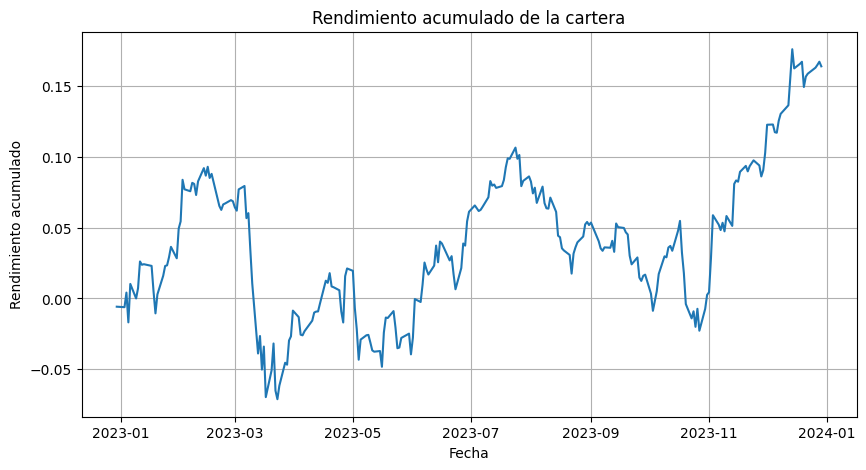

Rentabilidad media diaria = 0.0006535872913373468
Rentabilidad anualizada esperada = 0.1647039974170114
Volatilidad = 0.011854278612414065
Volatilidad anualizada = 0.1881808390831167


In [208]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(portfolio_ret.cumsum())
plt.title("Rendimiento acumulado de la cartera")
plt.xlabel("Fecha")
plt.ylabel("Rendimiento acumulado")
plt.grid(True)
plt.show()

print(f"Rentabilidad media diaria = {expected_portfolio_ret}")
print(f"Rentabilidad anualizada esperada = {expected_portfolio_ret * 252}")
print(f"Volatilidad = {expected_portfolio_std}")
print(f"Volatilidad anualizada = {expected_portfolio_std * np.sqrt(252)}")

¿Y qué podría pasar a partir de aquí?

In [236]:
import numpy as np

# Creamos el generador de números aleatorios.
rng = np.random.default_rng(seed=42)

# Generamos "num_escenarios" escenarios de "num_dias" rendimientos futuros (1 por día) siguiendo una distribución normal: recordad que las fechas van en las filas.
num_escenarios = 100
num_dias = 252
future_returns = rng.normal(
    loc=expected_portfolio_ret,
    scale=expected_portfolio_std,
    size=(num_dias, num_escenarios),  # "num_dias" días, "num_escenarios" escenarios
)
future_returns.shape

(252, 100)

¿Cómo es nuestro DataFrame de retornos de la cartera hasta el día de hoy?

In [211]:
portfolio_ret

Date
2022-12-30   -0.005791
2023-01-03   -0.000340
2023-01-04    0.010302
2023-01-05   -0.021044
2023-01-06    0.027172
                ...   
2023-12-22    0.002072
2023-12-26    0.004273
2023-12-27    0.002002
2023-12-28    0.002215
2023-12-29   -0.003258
Length: 251, dtype: float64

¿Cómo creamos un DataFrame con un índice que contenga las fechas que necesitamos (aquellas que van a continuación del último día de nuestro DataFrame)?

Ref.:
* Función ``bdate_range`` de Pandas: https://pandas.pydata.org/docs/reference/api/pandas.bdate_range.html

In [238]:
import pandas as pd

future_returns_df = pd.DataFrame(
    data=future_returns,
    index=pd.bdate_range(start="2023-12-30", periods=num_dias)
)
future_returns_df

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
2024-01-01,0.004266,-0.011675,0.009550,0.011803,-0.022475,-0.014783,0.002169,-0.003095,0.000454,-0.009459,...,0.008541,-0.000514,-0.004364,-0.000291,-0.019349,-0.016501,-0.015026,-0.011168,0.005393,-0.010080
2024-01-02,-0.003829,0.016055,-0.003570,0.009396,-0.010414,-0.001782,-0.010608,-0.003365,0.010615,-0.019823,...,0.021086,-0.001474,-0.003889,0.017978,-0.012470,-0.009953,0.008280,-0.004024,0.000593,-0.001284
2024-01-03,0.004655,0.017338,0.001727,0.008287,-0.023650,0.000076,-0.009342,-0.013795,-0.009756,-0.003307,...,-0.002333,0.002462,0.018097,-0.029772,-0.002154,0.002746,0.004162,-0.003755,-0.020171,0.004542
2024-01-04,0.021130,-0.017529,0.010894,-0.003241,-0.000073,-0.011828,-0.003311,0.016065,0.007561,0.021189,...,-0.026731,0.001298,-0.004939,0.006099,0.008975,0.002292,0.009664,0.003371,0.006937,-0.007700
2024-01-05,-0.001476,0.002986,0.010380,-0.004014,0.006832,-0.002498,-0.000740,0.010487,-0.022973,-0.014715,...,0.013519,0.004999,-0.002740,0.006035,-0.003006,0.011744,-0.021056,-0.003325,-0.022946,-0.017069
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-11,0.003003,0.028518,-0.009342,-0.010830,-0.003229,0.021290,-0.006185,0.005754,0.013350,0.009888,...,0.009739,0.001754,-0.007760,0.002780,-0.000014,0.017439,-0.005450,-0.006004,-0.007628,0.023139
2024-12-12,-0.006965,0.016027,-0.011573,0.006659,0.003765,0.015274,0.013556,0.001624,-0.005713,0.019916,...,0.000570,0.004318,-0.011131,0.009902,0.010686,-0.003558,0.005834,-0.019695,0.002788,-0.000925
2024-12-13,0.015581,-0.001701,0.010951,-0.003983,-0.026446,-0.002020,0.002986,0.002442,0.002621,-0.005350,...,0.002586,0.004437,0.001553,-0.006838,-0.001840,0.014654,-0.004380,0.000908,-0.005947,0.012750
2024-12-16,0.001576,-0.008403,0.000738,-0.002204,0.017162,0.000124,-0.015738,0.006565,0.021826,0.014842,...,-0.007936,-0.012892,-0.007030,-0.016792,0.003119,0.014684,0.017505,-0.012260,0.009981,0.001655


Y ahora, a pintarlo todo junto...

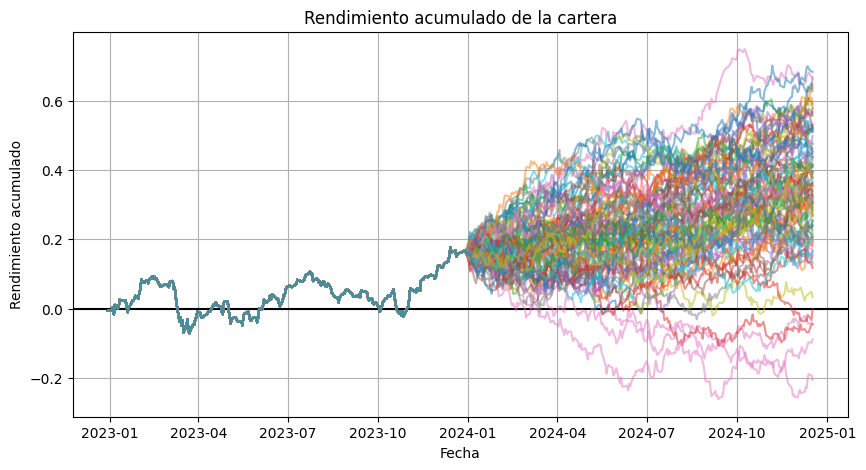

In [256]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(portfolio_ret.cumsum())
plt.axhline(0, color="black")
for idx in range(num_escenarios):
    plt.plot(pd.concat([portfolio_ret, future_returns_df[idx]]).cumsum(), alpha=0.5)
plt.title("Rendimiento acumulado de la cartera")
plt.xlabel("Fecha")
plt.ylabel("Rendimiento acumulado")
plt.grid(True)
plt.show()

¿Cómo es la distribución de los resultados?

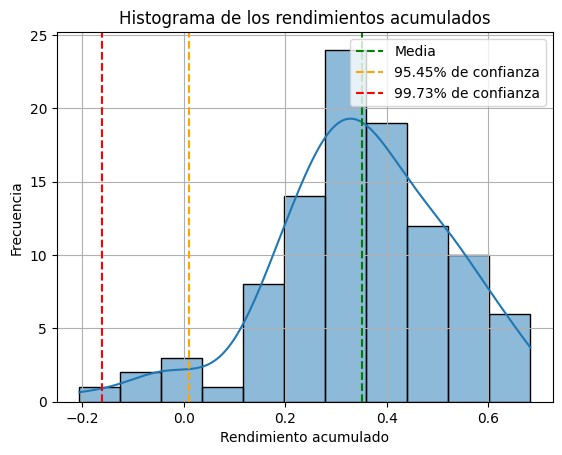

In [283]:
import seaborn as sns

r0 = portfolio_ret.sum()
serie = r0 + future_returns_df.sum()

sns.histplot(serie, kde=True)
# Media
plt.axvline(serie.mean(), color="green", linestyle="--", label="Media")
# 100% - 95.45% de los datos
plt.axvline(serie.mean() - 2 * serie.std(), color="orange", linestyle="--", label="95.45% de confianza")
# 100% - 99.73% de los datos
plt.axvline(serie.mean() - 3 * serie.std(), color="red", linestyle="--", label="99.73% de confianza")

plt.xlabel("Rendimiento acumulado")
plt.ylabel("Frecuencia")
plt.title("Histograma de los rendimientos acumulados")
plt.grid(True)
plt.legend()
plt.show()

Entonces ¿cuáles son mis escenarios central, mejor y peor con un 95.45% de confianza?

Ref.:
* Función ``quantile`` de Numpy: https://numpy.org/devdocs/reference/generated/numpy.quantile.html

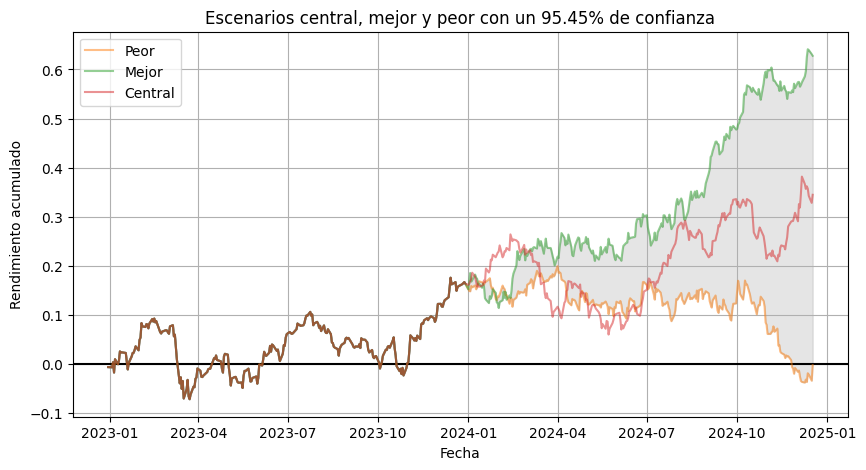

In [305]:
# Índices de los escenarios mejor, peor y central.
escenario_peor = serie[serie == np.quantile(serie, 1 - 0.9545, method="closest_observation")].index.values[0]
escenario_mejor = serie[serie == np.quantile(serie, 0.9545, method="closest_observation")].index.values[0]
escenario_central = serie[serie == np.quantile(serie, 0.5, method="closest_observation")].index.values[0]

# Series de retornos acumulados de los escenarios.
peor_cumsum = pd.concat([portfolio_ret, future_returns_df[escenario_peor]]).cumsum()
mejor_cumsum = pd.concat([portfolio_ret, future_returns_df[escenario_mejor]]).cumsum()
central_cumsum = pd.concat([portfolio_ret, future_returns_df[escenario_central]]).cumsum()

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

# Serie conocida (pasado).
plt.plot(portfolio_ret.cumsum())

# Línea horizontal en 0.
plt.axhline(0, color="black")

# Escenarios futuros.
plt.plot(peor_cumsum, alpha=0.5, label="Peor")
plt.plot(mejor_cumsum, alpha=0.5, label="Mejor")
plt.plot(central_cumsum, alpha=0.5, label="Central")

# Relleno entre las series.
plt.fill_between(peor_cumsum.index, peor_cumsum, mejor_cumsum, color="gray", alpha=0.2)

# Configuración del gráfico.
plt.title("Escenarios central, mejor y peor con un 95.45% de confianza")
plt.xlabel("Fecha")
plt.ylabel("Rendimiento acumulado")
plt.grid(True)
plt.legend()
plt.show()